In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
 
#import lightgbm as lgb
import catboost as catb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('course_project_test.csv')

In [3]:
df1 = deepcopy(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [5]:
df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   1.987000e+03  2500.000000              2500.000000   
mean    1.366922e+06     0.035200                11.184400   
std     9.171252e+05     0.386291                 4.852774   
min     1.065330e+05     0.000000                 1.000000   
25%     8.523115e+05     0.000000                 8.000000   
50%     1.178475e+06     0.000000                10.000000   
75%     1.629734e+06     0.000000                14.000000   
max     1.497561e+07    15.000000                48.000000   

       Years of Credit History  Maximum Open Credit  \
count              2500.000000         2.500000e+03   
mean                 18.325920         7.105704e+05   
std                   7.254659         1.511983e+06   
min                   3.900000         0.000000e+00   
25%                  13.400000         2.785860e+05   
50%                  17.000000         4.786760e+05   
75%                  22.100000         8.025985e+05   
max                  53.400000         5.448439e+07   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.162000                     34.181261      0.106928   
std                     0.559894                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                    15.000000                     82.000000      5.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count         2.500000e+03            2.500000e+03   2500.000000   1987.000000  
mean          1.215572e+07            2.963966e+05  18271.340000   1234.516860  
std           3.226097e+07            3.783020e+05  11543.881469   1740.219442  
min           1.542200e+04            0.000000e+00     93.000000    585.000000  
25%           1.871265e+05            1.101145e+05  10024.750000    710.000000  
50%           3.223660e+05            2.073850e+05  16642.500000    731.000000  
75%           5.225825e+05            3.663485e+05  24146.000000    743.000000  
max           1.000000e+08            6.030087e+06  93555.000000   7480.000000

## Обработка категориальных переменных

### Years in current job

In [6]:
df['Years in current job'] = df['Years in current job'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [7]:
df['Years in current job'].value_counts()

1    2414
0      86
Name: Years in current job, dtype: int64

### Home Ownership

In [8]:
def process_ownerchip(value):
    if value in ['Own Home', 'Rent']:
        return 0
    else:
        return 1

df['Home Ownership'] = df['Home Ownership'].apply(process_ownerchip)

In [9]:
df['Home Ownership'].value_counts()

0    1268
1    1232
Name: Home Ownership, dtype: int64

### Term

In [10]:
df['Term'] = df['Term'].apply(lambda x: 0 if x == 'Short Term' else 1)

In [11]:
df['Term'].value_counts()

0    1861
1     639
Name: Term, dtype: int64

### Purpose

In [12]:
def process_purpose(value):
    columns_0 = ['debt consolidation',
            'other',    
            'home improvements',
            'take a trip',
            'buy a car',
            'wedding',
            'buy house',
            'medical bills',
            'major purchase']
    columns_1 = ['business loan',
                 'small business']
    if value in columns_0:
        return 0
    elif value in columns_1:
        return 1
    else:
        return 2

df['Purpose'] = df['Purpose'].apply(process_purpose)

### Tax Liens

In [13]:
def process_tax(value):
    columns_0 = [0, 1]
    columns_1 = range(2, 6)
    columns_3 = [6, 7]
    if value in columns_0:
        return 0
    elif value in columns_1:
        return 1
    else:
        return 2

df['Tax Liens'] = df['Tax Liens'].apply(process_tax)

### Years of Credit History

In [14]:
df['Years of Credit History'] /= 5
df['Years of Credit History'] = df['Years of Credit History'].astype(int)

In [15]:
def convert_years_credit_history(value):

    if (value in [0, 1, 4]) or value >= 6:
        return 0
    elif value in [2, 3, 5]:
        return 1
df['Years of Credit History'] = df['Years of Credit History'].astype('int')
df['Years of Credit History'] = df['Years of Credit History'].apply(convert_years_credit_history)

### Number of Credit Problems

In [16]:
df['Number of Credit Problems'] = df['Number of Credit Problems'].apply(lambda x: 1 if x > 1 else 0)

### Number of Credit Problems + Tax Lies

In [17]:
df_clust = df.loc[:, ['Tax Liens', 'Number of Credit Problems']]

In [18]:
with open('cluster_scaler.bin', 'rb') as f:
    scaler = pickle.load(f)
train_scaled = scaler.transform(df_clust)

In [19]:
inertia_arr = []
for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=42)
    temp_model.fit(train_scaled)
    inertia_arr.append(temp_model.inertia_ )

<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)
<ipython-input-19-279199084f8c>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  temp_model.fit(train_scaled)


In [20]:
with open('cluster_model.bin', 'rb') as f:
    model = pickle.load(f)

In [21]:
df['tax_problems'] = model.fit_predict(train_scaled)

### Итого категориальные признаки:

In [22]:
CAT_FEATURES = ['Years in current job', 'Home Ownership', 'Term', 'Purpose', 
                'Years of Credit History', 'tax_problems']

In [23]:
df[CAT_FEATURES].describe()

Years in current job  Home Ownership         Term      Purpose  \
count           2500.000000     2500.000000  2500.000000  2500.000000   
mean               0.965600        0.492800     0.255600     0.019600   
std                0.182291        0.500048     0.436285     0.157562   
min                0.000000        0.000000     0.000000     0.000000   
25%                1.000000        0.000000     0.000000     0.000000   
50%                1.000000        0.000000     0.000000     0.000000   
75%                1.000000        1.000000     1.000000     0.000000   
max                1.000000        1.000000     1.000000     2.000000   

       Years of Credit History  tax_problems  
count              2500.000000   2500.000000  
mean                  0.656400      1.009200  
std                   0.475005      0.130852  
min                   0.000000      0.000000  
25%                   0.000000      1.000000  
50%                   1.000000      1.000000  
75%                   1.000000      1.000000  
max                   1.000000      2.000000

In [24]:
df[CAT_FEATURES] = df[CAT_FEATURES].astype('uint8')
df['tax_problems'] = df['tax_problems'].astype(object)
df['Purpose'] = df['Purpose'].astype(object)
df = pd.get_dummies(df)

In [25]:
CAT_FEATURES = ['Years in current job', 'Home Ownership', 'Term',
 'Years of Credit History', 'Purpose_0', 'Purpose_1', 'Purpose_2',
 'tax_problems_0', 'tax_problems_1', 'tax_problems_2']
df[CAT_FEATURES].describe()

Years in current job  Home Ownership         Term  \
count           2500.000000     2500.000000  2500.000000   
mean               0.965600        0.492800     0.255600   
std                0.182291        0.500048     0.436285   
min                0.000000        0.000000     0.000000   
25%                1.000000        0.000000     0.000000   
50%                1.000000        0.000000     0.000000   
75%                1.000000        1.000000     1.000000   
max                1.000000        1.000000     1.000000   

       Years of Credit History    Purpose_0    Purpose_1    Purpose_2  \
count              2500.000000  2500.000000  2500.000000  2500.000000   
mean                  0.656400     0.983200     0.014000     0.002800   
std                   0.475005     0.128547     0.117514     0.052851   
min                   0.000000     0.000000     0.000000     0.000000   
25%                   0.000000     1.000000     0.000000     0.000000   
50%                   1.000000     1.000000     0.000000     0.000000   
75%                   1.000000     1.000000     0.000000     0.000000   
max                   1.000000     1.000000     1.000000     1.000000   

       tax_problems_0  tax_problems_1  tax_problems_2  
count     2500.000000     2500.000000     2500.000000  
mean         0.004000        0.982800        0.013200  
std          0.063132        0.130042        0.114153  
min          0.000000        0.000000        0.000000  
25%          0.000000        1.000000        0.000000  
50%          0.000000        1.000000        0.000000  
75%          0.000000        1.000000        0.000000  
max          1.000000        1.000000        1.000000

## Числовые признаки

In [26]:
with open('lambdas.bin', 'rb') as f:
    lambdas = pickle.load(f)

In [27]:
lambdas

{'max_credit_lambda': 0.22046164596449688,
 'credit_balance_lambda': 0.35171364548679723,
 'loan_amount_lambda': 0.3620896643157912,
 'number_accounts_lambda': 0.19648893786669672,
 'month_dept_lambda': 0.438109113536189,
 'annual_income_lambda': -0.013750754533739432,
 'credit_score_lambda': 18.64423567315302}

### Maximum Open Credit

In [28]:
df['Maximum Open Credit'].shape

(2500,)

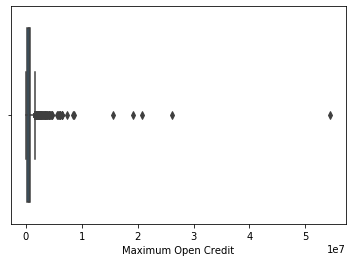

In [29]:
sns.boxplot(df['Maximum Open Credit'])

In [30]:
df['Maximum Open Credit'].sort_values(ascending=False).head(10)

228     54484386.0
1568    26069956.0
2152    20842404.0
584     19185386.0
222     15568542.0
1455     8693828.0
1872     8440410.0
2014     7343028.0
285      6425034.0
1683     6404046.0
Name: Maximum Open Credit, dtype: float64

In [31]:
df['Maximum Open Credit'] = sp.stats.yeojohnson(df['Maximum Open Credit'], lambdas['max_credit_lambda'])

### Current Credit Balance

In [32]:
df['Current Credit Balance'] = sp.stats.yeojohnson(df['Current Credit Balance'], lambdas['credit_balance_lambda'])

### Current Loan Amount

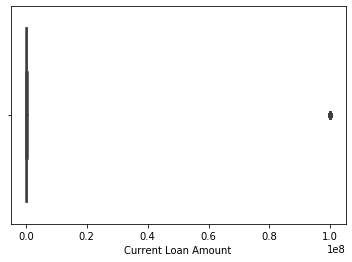

In [33]:
sns.boxplot(df['Current Loan Amount'])

In [34]:
df['Current Loan Max'] = (df['Current Loan Amount'] / 99999999.0)
df['Current Loan Max'] = df['Current Loan Max'].astype(int)
CAT_FEATURES.append('Current Loan Max')

In [35]:
df['Current Loan Max'].value_counts()

0    2203
1     297
Name: Current Loan Max, dtype: int64

In [36]:
CAT_FEATURES

['Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_0',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'tax_problems_1',
 'tax_problems_2',
 'Current Loan Max']

In [37]:
df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = 264704.0

In [38]:
df['Current Loan Amount'] = sp.stats.yeojohnson(df['Current Loan Amount'], lambdas['loan_amount_lambda'])

In [39]:
df.describe()

Home Ownership  Annual Income  Years in current job    Tax Liens  \
count     2500.000000   1.987000e+03           2500.000000  2500.000000   
mean         0.492800   1.366922e+06              0.965600     0.004800   
std          0.500048   9.171252e+05              0.182291     0.079872   
min          0.000000   1.065330e+05              0.000000     0.000000   
25%          0.000000   8.523115e+05              1.000000     0.000000   
50%          0.000000   1.178475e+06              1.000000     0.000000   
75%          1.000000   1.629734e+06              1.000000     0.000000   
max          1.000000   1.497561e+07              1.000000     2.000000   

       Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
count              2500.000000              2500.000000          2500.000000   
mean                 11.184400                 0.656400            77.351626   
std                   4.852774                 0.475005            16.847585   
min                   1.000000                 0.000000             0.000000   
25%                   8.000000                 0.000000            67.420887   
50%                  10.000000                 1.000000            76.541214   
75%                  14.000000                 1.000000            86.326107   
max                  48.000000                 1.000000           225.723919   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.017200                     34.181261      0.106928   
std                     0.130042                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     1.000000                     82.000000      5.000000   

       ...  Current Credit Balance  Monthly Debt  Credit Score    Purpose_0  \
count  ...             2500.000000   2500.000000   1987.000000  2500.000000   
mean   ...              212.588524  18271.340000   1234.516860     0.983200   
std    ...               75.355344  11543.881469   1740.219442     0.128547   
min    ...                0.000000     93.000000    585.000000     0.000000   
25%    ...              165.849967  10024.750000    710.000000     1.000000   
50%    ...              207.919914  16642.500000    731.000000     1.000000   
75%    ...              254.616172  24146.000000    743.000000     1.000000   
max    ...              686.670844  93555.000000   7480.000000     1.000000   

         Purpose_1    Purpose_2  tax_problems_0  tax_problems_1  \
count  2500.000000  2500.000000     2500.000000     2500.000000   
mean      0.014000     0.002800        0.004000        0.982800   
std       0.117514     0.052851        0.063132        0.130042   
min       0.000000     0.000000        0.000000        0.000000   
25%       0.000000     0.000000        0.000000        1.000000   
50%       0.000000     0.000000        0.000000        1.000000   
75%       0.000000     0.000000        0.000000        1.000000   
max       1.000000     1.000000        1.000000        1.000000   

       tax_problems_2  Current Loan Max  
count     2500.000000       2500.000000  
mean         0.013200          0.118800  
std          0.114153          0.323618  
min          0.000000          0.000000  
25%          0.000000          0.000000  
50%          0.000000          0.000000  
75%          0.000000          0.000000  
max          1.000000          1.000000  

[8 rows x 22 columns]

### Number of Open Accounts

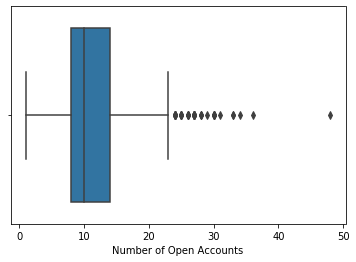

In [40]:
sns.boxplot(df['Number of Open Accounts'])

In [41]:
mdn = df['Number of Open Accounts'].median()
mdn

10.0

In [42]:
df['Number of Open Accounts'] = df['Number of Open Accounts'].apply(lambda x: 10 if x > 25 else x)

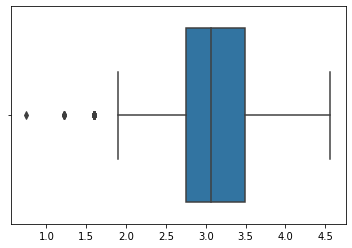

In [43]:
sns.boxplot(sp.stats.yeojohnson(df['Number of Open Accounts'], lambdas['number_accounts_lambda']))

In [44]:
df['Number of Open Accounts'] = sp.stats.yeojohnson(df['Number of Open Accounts'], lambdas['number_accounts_lambda'])

### Monthly Debt

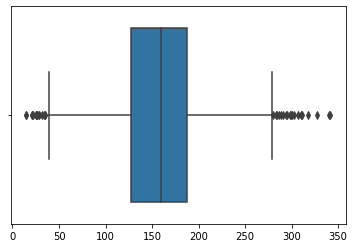

In [45]:
sns.boxplot(sp.stats.yeojohnson(df['Monthly Debt'], lambdas['month_dept_lambda']))

In [46]:
df['Monthly Debt'] = sp.stats.yeojohnson(df['Monthly Debt'], lambdas['month_dept_lambda'])

### Annual Income

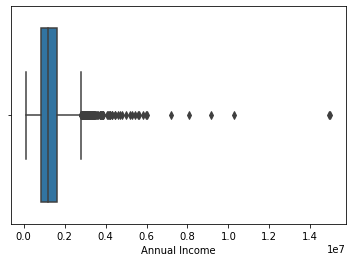

In [47]:
sns.boxplot(df['Annual Income'])

In [48]:
df_with_income = df.loc[(df['Annual Income'] >= 0)]

In [49]:
quant25, quant75 = np.quantile(df_with_income['Annual Income'], [.25, .75])
iqr = sp.stats.iqr(df_with_income['Annual Income'])

In [50]:
df_with_income = df_with_income.loc[(df_with_income['Annual Income'] > quant25-3*iqr) &
                                           (df_with_income['Annual Income'] < quant75+3*iqr)]

In [51]:
df1 = deepcopy(df)

In [52]:
df1 = df1[CAT_FEATURES+['Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Annual Income']]

In [53]:
df1.describe()

Years in current job  Home Ownership         Term  \
count           2500.000000     2500.000000  2500.000000   
mean               0.965600        0.492800     0.255600   
std                0.182291        0.500048     0.436285   
min                0.000000        0.000000     0.000000   
25%                1.000000        0.000000     0.000000   
50%                1.000000        0.000000     0.000000   
75%                1.000000        1.000000     1.000000   
max                1.000000        1.000000     1.000000   

       Years of Credit History    Purpose_0    Purpose_1    Purpose_2  \
count              2500.000000  2500.000000  2500.000000  2500.000000   
mean                  0.656400     0.983200     0.014000     0.002800   
std                   0.475005     0.128547     0.117514     0.052851   
min                   0.000000     0.000000     0.000000     0.000000   
25%                   0.000000     1.000000     0.000000     0.000000   
50%                   1.000000     1.000000     0.000000     0.000000   
75%                   1.000000     1.000000     0.000000     0.000000   
max                   1.000000     1.000000     1.000000     1.000000   

       tax_problems_0  tax_problems_1  tax_problems_2  Current Loan Max  \
count     2500.000000     2500.000000     2500.000000       2500.000000   
mean         0.004000        0.982800        0.013200          0.118800   
std          0.063132        0.130042        0.114153          0.323618   
min          0.000000        0.000000        0.000000          0.000000   
25%          0.000000        1.000000        0.000000          0.000000   
50%          0.000000        1.000000        0.000000          0.000000   
75%          0.000000        1.000000        0.000000          0.000000   
max          1.000000        1.000000        1.000000          1.000000   

       Maximum Open Credit  Number of Open Accounts  Current Loan Amount  \
count          2500.000000              2500.000000          2500.000000   
mean             77.351626                 3.106797           254.958720   
std              16.847585                 0.606154            56.011899   
min               0.000000                 0.742567            87.952715   
25%              67.420887                 2.747838           221.198228   
50%              76.541214                 3.063028           251.165905   
75%              86.326107                 3.487800           291.813659   
max             225.723919                 4.564237           374.353278   

       Current Credit Balance  Monthly Debt  Annual Income  
count             2500.000000   2500.000000   1.987000e+03  
mean               212.588524    157.270117   1.366922e+06  
std                 75.355344     47.018514   9.171252e+05  
min                  0.000000     14.423099   1.065330e+05  
25%                165.849967    126.941547   8.523115e+05  
50%                207.919914    159.072850   1.178475e+06  
75%                254.616172    187.645910   1.629734e+06  
max                686.670844    341.504506   1.497561e+07

In [54]:
df1.loc[df_with_income.index, 'Annual Income'] = df_with_income['Annual Income']

In [55]:
df_income_res = df1.loc[pd.isnull(df1['Annual Income'])]

In [56]:
NUM_FEAT = ['Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [57]:
with open('annual_scaler.bin', 'rb') as f:
    scaler = pickle.load(f)

In [58]:
df_income_res[NUM_FEAT] = scaler.transform(df_income_res[NUM_FEAT])

<ipython-input-58-7639fb00f29e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income_res[NUM_FEAT] = scaler.transform(df_income_res[NUM_FEAT])
/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [59]:
with open('annual_regressor.bin', 'rb') as f:
    regressor = pickle.load(f)

In [60]:
FEATURES = CAT_FEATURES + NUM_FEAT
FEATURES

['Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_0',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'tax_problems_1',
 'tax_problems_2',
 'Current Loan Max',
 'Maximum Open Credit',
 'Number of Open Accounts',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt']

In [61]:
df_income_res['Annual Income'] = regressor.predict(df_income_res.loc[:, FEATURES])
df_income_res['Annual Income'].describe()

<ipython-input-61-44489f7aa765>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income_res['Annual Income'] = regressor.predict(df_income_res.loc[:, FEATURES])


count    5.130000e+02
mean     1.351813e+06
std      5.005397e+05
min      6.332050e+05
25%      1.002015e+06
50%      1.233636e+06
75%      1.573406e+06
max      4.167369e+06
Name: Annual Income, dtype: float64

In [62]:
df.loc[df_income_res.index, 'Annual Income'] = df_income_res['Annual Income']

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   uint8  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   uint8  
 3   Tax Liens                     2500 non-null   int64  
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   uint8  
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int64  
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Term                          2500 non-null   uint8  
 11  Current Loan Amount           2500 non-null   float64
 12  Current Credit Balance        2500 non-null   float64
 13  Mon

### Credit Score

In [64]:
df['Credit Score Max'] = df['Credit Score'] >= 6000
df['Credit Score Max'] = df['Credit Score Max'].apply(lambda x: 1 if x else 0)

In [65]:
df['Credit Score'] = df['Credit Score'].apply(lambda x: 730 if x >= 6000 else x)

In [66]:
df1 = deepcopy(df)

In [67]:
df1 = df1[['Years in current job', 'Home Ownership', 'Term', 'Years of Credit History', 'Purpose_0',
 'Purpose_1', 'Purpose_2', 'tax_problems_0', 'tax_problems_1', 'tax_problems_2',
 'Current Loan Max',]+['Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Annual Income', 'Credit Score']]

In [68]:
df_score_res = df1.loc[df1['Credit Score']>0]

In [69]:
with open('score_scaler.bin', 'rb') as f:
    scaler = pickle.load(f)

In [70]:
df_score_res

Years in current job  Home Ownership  Term  Years of Credit History  \
1                        1               0     0                        0   
2                        1               1     0                        1   
3                        1               1     0                        1   
4                        1               1     1                        0   
5                        1               1     0                        1   
...                    ...             ...   ...                      ...   
2494                     1               1     1                        1   
2495                     1               1     0                        1   
2497                     1               1     0                        1   
2498                     1               0     0                        1   
2499                     1               0     1                        1   

      Purpose_0  Purpose_1  Purpose_2  tax_problems_0  tax_problems_1  \
1             0          0          1               0               1   
2             1          0          0               0               1   
3             1          0          0               0               1   
4             1          0          0               0               1   
5             1          0          0               0               1   
...         ...        ...        ...             ...             ...   
2494          1          0          0               0               1   
2495          1          0          0               0               1   
2497          1          0          0               0               1   
2498          1          0          0               0               1   
2499          1          0          0               0               1   

      tax_problems_2  Current Loan Max  Maximum Open Credit  \
1                  0                 0            45.973165   
2                  0                 0            62.687145   
3                  0                 0            75.690085   
4                  0                 0            94.883616   
5                  0                 0            83.990341   
...              ...               ...                  ...   
2494               0                 0            74.990359   
2495               0                 1            79.366974   
2497               0                 0           102.764996   
2498               0                 0            89.674623   
2499               0                 0            94.746684   

      Number of Open Accounts  Current Loan Amount  Current Credit Balance  \
1                    2.370234           160.604532              121.291269   
2                    3.063028           226.732986              183.664570   
3                    3.791034           233.687584              209.979481   
4                    3.203605           372.360571              268.508632   
5                    3.063028           171.800601              178.622251   
...                       ...                  ...                     ...   
2494                 3.575301           283.560953              153.218544   
2495                 3.575301           251.165905              190.692301   
2497                 3.063028           300.059417              316.591227   
2498                 3.575301           248.738395              260.639959   
2499                 3.335064           369.789686              295.969608   

      Monthly Debt  Annual Income  Credit Score  
1        65.760963       231838.0         699.0  
2       167.641748      1152540.0         730.0  
3       198.971455      1220313.0         739.0  
4       241.291529      2340952.0         706.0  
5       133.095638       922583.0         679.0  
...            ...            ...           ...  
2494    168.074280       907839.0         705.0  
2495    152.099439      1020053.0         745.0  
2497    226.456668      1171806.0         695.0  
2498    14

In [71]:
NUM_FEAT = ['Maximum Open Credit', 'Number of Open Accounts',
            'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [72]:
df_score_res.loc[:, NUM_FEAT] = scaler.transform(df_score_res.loc[:, NUM_FEAT])

/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [73]:
with open('score_regressor.bin', 'rb') as f:
    regressor = pickle.load(f)

In [74]:
FEATURES = ['Years in current job', 'Home Ownership', 'Term', 'Years of Credit History', 'Purpose_0',
 'Purpose_1', 'Purpose_2', 'tax_problems_0', 'tax_problems_1', 'tax_problems_2',
 'Current Loan Max', 'Maximum Open Credit', 'Number of Open Accounts',
                        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

In [75]:
df_score_res.loc[:, 'Credit Score'] = regressor.predict(df_score_res.loc[:, FEATURES])
df_score_res['Credit Score'].describe()

/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


count    1987.000000
mean      721.072202
std        14.540089
min       668.203685
25%       712.959390
50%       725.320640
75%       730.913548
max       746.224506
Name: Credit Score, dtype: float64

In [76]:
df.loc[df_score_res.index, 'Credit Score'] = df_score_res['Credit Score']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   uint8  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   uint8  
 3   Tax Liens                     2500 non-null   int64  
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   uint8  
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int64  
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Term                          2500 non-null   uint8  
 11  Current Loan Amount           2500 non-null   float64
 12  Current Credit Balance        2500 non-null   float64
 13  Mon

In [159]:
df['Credit Score'] = sp.stats.yeojohnson(df['Credit Score'], lambdas['credit_score_lambda'])

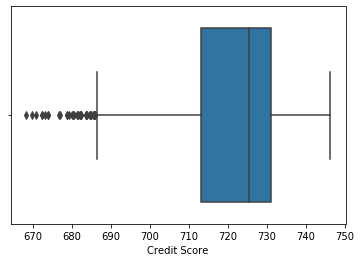

In [77]:
sns.boxplot(df['Credit Score'])

In [78]:
CAT_FEATURES.append('Credit Score Max')

In [79]:
NUM_FEATURES = ['Maximum Open Credit',
 'Current Loan Amount',
 'Annual Income',
 'Number of Open Accounts',
 'Monthly Debt',
 'Credit Score']

In [80]:
CAT_FEATURES = ['Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_0',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'tax_problems_1',
 'tax_problems_2',]

In [81]:
FEATURE_NAMES = ['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'Credit Score Max', 'Current Loan Max']

## Классификация

In [82]:
with open('model_scaler', 'rb') as f:
    scaler = pickle.load(f)

In [83]:
df[NUM_FEATURES] = scaler.transform(df[NUM_FEATURES])

In [84]:
df[NUM_FEATURES].describe()

Maximum Open Credit  Current Loan Amount  Annual Income  \
count          2500.000000          2500.000000   2.500000e+03   
mean              0.118808             0.018341   3.523029e+06   
std               1.302182             1.013465   2.191668e+06   
min              -5.859847            -3.003421   2.751662e+05   
25%              -0.648757            -0.592512   2.311325e+06   
50%               0.056170            -0.050285   3.102914e+06   
75%               0.812463             0.685185   4.175899e+06   
max              11.586787             2.178635   3.868539e+07   

       Number of Open Accounts  Monthly Debt  Credit Score  
count              2500.000000   2500.000000   1987.000000  
mean                  0.001768      0.030733      0.037717  
std                   0.963759      1.084822      0.579078  
min                  -3.757258     -3.265066     -2.067838  
25%                  -0.568962     -0.669015     -0.285386  
50%                  -0.067823      0.072326      0.206917  
75%                   0.607546      0.731570      0.429662  
max                   2.319037      4.281431      1.039440

In [85]:
df['Credit Score Max'].value_counts()

0    2340
1     160
Name: Credit Score Max, dtype: int64

In [86]:
df['Number of Open Accounts'].describe()

count    2500.000000
mean        0.001768
std         0.963759
min        -3.757258
25%        -0.568962
50%        -0.067823
75%         0.607546
max         2.319037
Name: Number of Open Accounts, dtype: float64

In [87]:
with open('model_class.bin', 'rb') as f:
    final_model = pickle.load(f)

In [88]:
df['Maximum Open Credit'].min(), df['Maximum Open Credit'].max()

(-5.85984664050229, 11.586786633992581)

In [89]:
df1 = deepcopy(df)

In [91]:
y = final_model.predict(df1[FEATURE_NAMES])

In [92]:
y_proba = final_model.predict_proba(df1[FEATURE_NAMES])

In [107]:
s = pd.Series(data=(y_proba[:,1] > 0.4).astype(int), name='Credit Default')

In [108]:
s.to_csv('KKrasov_predict_default.csv', index=False)

In [105]:
y1 = (y_proba[:,1] > 0.4).astype(int)

In [106]:
len(y1[y1==1])

197

In [97]:
len(y[y==1])

164

In [99]:
df[CAT_FEATURES].describe()

Years in current job  Home Ownership         Term  \
count           2500.000000     2500.000000  2500.000000   
mean               0.965600        0.492800     0.255600   
std                0.182291        0.500048     0.436285   
min                0.000000        0.000000     0.000000   
25%                1.000000        0.000000     0.000000   
50%                1.000000        0.000000     0.000000   
75%                1.000000        1.000000     1.000000   
max                1.000000        1.000000     1.000000   

       Years of Credit History    Purpose_0    Purpose_1    Purpose_2  \
count              2500.000000  2500.000000  2500.000000  2500.000000   
mean                  0.656400     0.983200     0.014000     0.002800   
std                   0.475005     0.128547     0.117514     0.052851   
min                   0.000000     0.000000     0.000000     0.000000   
25%                   0.000000     1.000000     0.000000     0.000000   
50%                   1.000000     1.000000     0.000000     0.000000   
75%                   1.000000     1.000000     0.000000     0.000000   
max                   1.000000     1.000000     1.000000     1.000000   

       tax_problems_0  tax_problems_1  tax_problems_2  
count     2500.000000     2500.000000     2500.000000  
mean         0.004000        0.982800        0.013200  
std          0.063132        0.130042        0.114153  
min          0.000000        0.000000        0.000000  
25%          0.000000        1.000000        0.000000  
50%          0.000000        1.000000        0.000000  
75%          0.000000        1.000000        0.000000  
max          1.000000        1.000000        1.000000

In [100]:
FEATURE_NAMES

['Maximum Open Credit',
 'Current Loan Amount',
 'Number of Open Accounts',
 'Monthly Debt',
 'Annual Income',
 'Credit Score',
 'Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'Credit Score Max',
 'Current Loan Max']